# <center>🦾🤖 2.4 - Валидация - а зачем?</center>

<center> <img src = 'https://scikit-learn.org/stable/_images/grid_search_workflow.png' width=600> </center>

* Полезно пробежаться по валидации из `Scikit-Learn` https://scikit-learn.org/stable/modules/cross_validation.html

# ⚖️ Какие есть техники валидации?

* `KFold` - кросс-итератор для K-фолдной валидации.
* `StratifiedKFold` - он же, но еще и стратифицированный (сбалансированный).
* `GroupKFold` - K-фрагментный вариант итератора с непересекающимися группами.
* `RepeatedKFold` - K-фолдная валидация с повторениями.

<center> <img src = 'https://scikit-learn.ru/wp-content/uploads/2021/10/image-161.png' width=900> </center>

## 🍭 Какие валидации полезно попробовать?

* `StratifiedGroupKFold` - он же, но еще и стратифицированный (сбалансированный)
* `RepeatedStratifiedKFold` - а тут стратифицированный, но еще дополнительно с повторениями
* А где взять `RepeatedStratifiedGroupKFold`? :)

## Еще несколько 

* `Shuffle Split` - сначала перемешивает все сэмплы, потом разделяет на заданное количество фолдов.
* `Time Series Split` - используется, когда данные упорядочены по времени.<br>
<br>
* `Leave One Out (LOO)` - удаляет только 1 сэмпл данных из датасета для каждого фолда (создает все возможные наборы для обучения).
* `Leave One Group Out` - то же самое, но каждый раз удаляет 1 группу сэмплов.
* `Leave P Out` - удаляет P сэмплов из датасета и создает все возможные наборы, значения в наборах могут повторяться.

<div class="alert alert-info">
    
# 🍕 Когда какую выбрать? 
- Есть временная зависимость?  ➡️ `TimeSeriesSplit`
- Мало данных и быстро учится?  ➡️ `LeaveOneOut` 
- Много данных, но быстро учится?  ➡️ `KFold`
- Очень много данных и долго учится?  ➡️ старый добрый `train_test_split()`
- Есть дисбаланс классов?  ➡️ Любой итератор с приставкой `Stratified`
- Есть группы и нельзя допусть их одновременного присутствия в `train` и `test`?  ➡️ Любой итератор с приставкой `Group`

# 📂 Импорт библиотек

In [ ]:
#!pip install --upgrade seaborn pandas numpy -q
#!pip install -U scikit-learn -q

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# 💾 Импорт данных по машинам

In [2]:
train = pd.read_csv("../data/car_train.csv")
test = pd.read_csv("../data/car_test.csv")
# train.hist(figsize=(25, 5), layout=(-1, 5))
train.sample(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1623,C-1160143Y,Kia Sportage,standart,petrol,5.52,2012,27077,2015,36.57,break_bug
106,S61532080S,Hyundai Solaris,economy,petrol,4.00,2012,19243,2014,44.97,engine_overheat
1530,R61678217L,Kia Rio X-line,economy,petrol,4.60,2014,57754,2020,31.44,wheel_shake


# ⚙️ Базовый `Feature engineering` - генерируем и добавляем признаки 

In [3]:
path = "../data/rides_info.csv"
rides = pd.read_csv(path)  # Данные по поездкам
# rides.hist(figsize=(15, 5), layout=(-1, 3))
rides.sample(3)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
69934,K18652368z,F-1309656v,B1v,2020-03-26,6.97,49,583,42,72.0,1,1973.408433,0,7.541136,23.244
306999,l46218787Q,V21733186R,k1w,2020-02-03,0.10,113,1237,26,93.0,1,1555.374118,0,14.643724,0.374
721516,X11180141G,y35238235q,r1d,2020-02-29,0.67,79,626,27,89.0,2,1891.847109,0,-1.460211,2.278


In [4]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby("car_id", as_index=False).agg(
    mean_rating=("rating", "mean"),
    distance_sum=("distance", "sum"),
    rating_min=("rating", "min"),
    speed_max=("speed_max", "max"),
    user_ride_quality_median=("user_ride_quality", "median"),
    deviation_normal_count=("deviation_normal", "count"),
    user_uniq=("user_id", f),
)


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1049127W,4.255172,1.125753e+07,0.1,179.729652,-0.288229,174,172
1,A-1079539w,4.088046,1.912765e+07,0.1,184.505566,2.508746,174,173


In [5]:
def add_featues(df):

    if "mean_rating" not in df.columns:
        return df.merge(rides_df_gr, on="car_id", how="left")

    return df


train = add_featues(train)
test = add_featues(test)

# Закодируем категориальные признаки (`o-h-e`)

In [6]:
cat_features = ["car_type", "fuel_type", "model"]
train = pd.get_dummies(train, columns=cat_features)
test = pd.get_dummies(test, columns=cat_features)

train.head(4)

,car_id,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,...,model_Renault Sandero,model_Skoda Rapid,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4
0,y13744087j,3.78,2015,76163,2021,108.53,another_bug,4.737759,1.214131e+07,0.1,...,False,False,False,False,False,False,False,False,False,False
1,O41613818T,3.90,2015,78218,2021,35.20,electro_bug,4.480517,1.803909e+07,0.0,...,False,False,False,False,False,False,False,True,False,False
2,d-2109686j,6.30,2012,23340,2017,38.62,gear_stick,4.768391,1.588366e+07,0.1,...,True,False,False,False,False,False,False,False,False,False
3,u29695600e,4.04,2011,1263,2020,30.34,engine_fuel,3.880920,1.651883e+07,0.1,...,False,False,False,False,False,False,False,False,False,False


# Классифицируем признаки

In [7]:
features2drop = ["car_id", "target_reg"]  # То, что можно выбросить
targets = ["target_class", "target_reg"]  # Таргеты
cat_features = ["car_type", "fuel_type", "model"]

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print("cat_features :", len(cat_features), cat_features)
print("num_features :", len(num_features), num_features)
print("targets", targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 43 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq', 'car_type_business', 'car_type_economy', 'car_type_premium', 'car_type_standart', 'fuel_type_electro', 'fuel_type_petrol', 'model_Audi A3', 'model_Audi A4', 'model_Audi Q3', 'model_BMW 320i', 'model_Fiat 500', 'model_Hyundai Solaris', 'model_Kia Rio', 'model_Kia Rio X', 'model_Kia Rio X-line', 'model_Kia Sportage', 'model_MINI CooperSE', 'model_Mercedes-Benz E200', 'model_Mercedes-Benz GLC', 'model_Mini Cooper', 'model_Nissan Qashqai', 'model_Renault Kaptur', 'model_Renault Sandero', 'model_Skoda Rapid', 'model_Smart Coupe', 'model_Smart ForFour', 'model_Smart ForTwo', 'model_Tesla Model 3', 'model_VW Polo', 'model_VW Polo VI', 'model_VW Tiguan', 'model_Volkswagen ID.4 ']
targets ['target_class', 'target_reg']


# 👩‍🏫 Учим `Random Forest` с `K-Fold` валидацией

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold

In [9]:
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train[["target_class"]]

n_splits = 5
clfs = []
scores = []

# параметры валидации, обучение будет идти на n_splits (фолдах)
kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for num, (train_index, test_index) in enumerate(kf.split(X)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    clf = RandomForestClassifier(
        n_estimators=2_000,
        min_samples_leaf=4,
        n_jobs=-1,
        max_features=0.60,
        # class_weight = 'balanced',
        random_state=7575,
        max_depth=6,
    )

    clfs.append(clf)  # Сохраняем модель для дальнейшего использования

    clf.fit(X_train, y_train["target_class"])

    y_pred = clf.predict(X_test)
    score = np.mean(np.array(y_pred == y_test["target_class"]))
    scores.append(score)
    print(f"fold: {num} acc: {score}")

assert len(clfs) == n_splits  # Проверка, что все ок

# Считаем среднее и дисперсию по всем фолдам
print("mean accuracy score --", np.mean(scores, dtype="float16"), np.std(scores).round(4))

fold: 0 acc: 0.8098290598290598
fold: 1 acc: 0.7841880341880342
fold: 2 acc: 0.8222698072805139
fold: 3 acc: 0.7751605995717344
fold: 4 acc: 0.7944325481798715
mean accuracy score -- 0.7974 0.017


<div class="alert alert-info">

## TODO-лист хорошей валидации    
    
* Фиксируем все `random_state`!
* Сохраняем модели всех фолдов, для инференса!
* Считаем не только среднее, но и дисперсию [если дисперсия высокая (в зависимости от задачи), то имеет место оверфит или утечка данных (`dataleak`)]
* Прикручиваем раннюю остановку `Early Stopping`
* Считаем кастомную метрику соревнования (особенно, если она комплексная)

# 👨‍🏫 Учим `Random Forest` со `Stratified K-Fold` валидацией

In [10]:
clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7575)

for train_index, test_index in kf.split(X=X, y=y["target_class"]):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # print(X_train.shape, y_train.shape)
    clf = RandomForestClassifier(
        n_estimators=2_000,
        min_samples_leaf=4,
        n_jobs=-1,
        max_features=0.60,
        random_state=7575,
        max_depth=6,
    )
    clfs.append(clf)

    clf.fit(X_train, y_train["target_class"])

    y_pred = clf.predict(X_test)
    score = np.mean(np.array(y_pred == y_test["target_class"]))
    scores.append(score)
    print(f"fold: acc: {score}")

assert len(clfs) == n_splits
print(
    "mean accuracy score --", np.mean(scores, dtype="float16"), np.std(scores).round(4)
)

fold: acc: 0.7927350427350427
fold: acc: 0.8311965811965812
fold: acc: 0.8072805139186295
fold: acc: 0.7987152034261242
fold: acc: 0.7815845824411135
mean accuracy score -- 0.8022 0.0167


# 🍏 Полезная привычка

записывай скоры валидации в ячейку и их лидерборд значение

In [11]:
# mean acc score -- 0.723 0.0179 --> LB 0.770
# mean acc score -- 0.645 0.0351 --> LB 0.560
# mean acc score -- 0.532 0.0232 --> LB 0.410
# mean acc score -- 0.412 0.0513 --> LB 0.250
# mean acc score -- 0.278 0.0287 --> LB 0.100

# 💣 Делаем прогноз для теста (инференс)

In [13]:
# массив для записи финального прогноза size*n_class
y_pred = np.zeros((test.shape[0], train[targets].nunique()[0]))

# Используем все модели из списка clfs для инференса
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(test[filtered_features])

f = lambda x: clf.classes_[x]
test["target_class"] = list(map(f, y_pred.argmax(axis=1)))

test[["car_id", "target_class"]].to_csv("rforest_kfold.csv", index=False)
test[["car_id", "target_class"]].head()

/var/tmp/ipykernel_21198/1436451665.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = np.zeros((test.shape[0], train[targets].nunique()[0]))


,car_id,target_class
0,P17494612l,engine_overheat
1,N-1530212S,electro_bug
2,B-1154399t,break_bug
3,F12725233R,gear_stick
4,l-1139189J,electro_bug


# 🤔 А на что опирается модель? -  `Feature Importance` 

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

Всего признаков 43 Усреднее по 5-ти моделям: 
На график нанесено топ-43 признаков


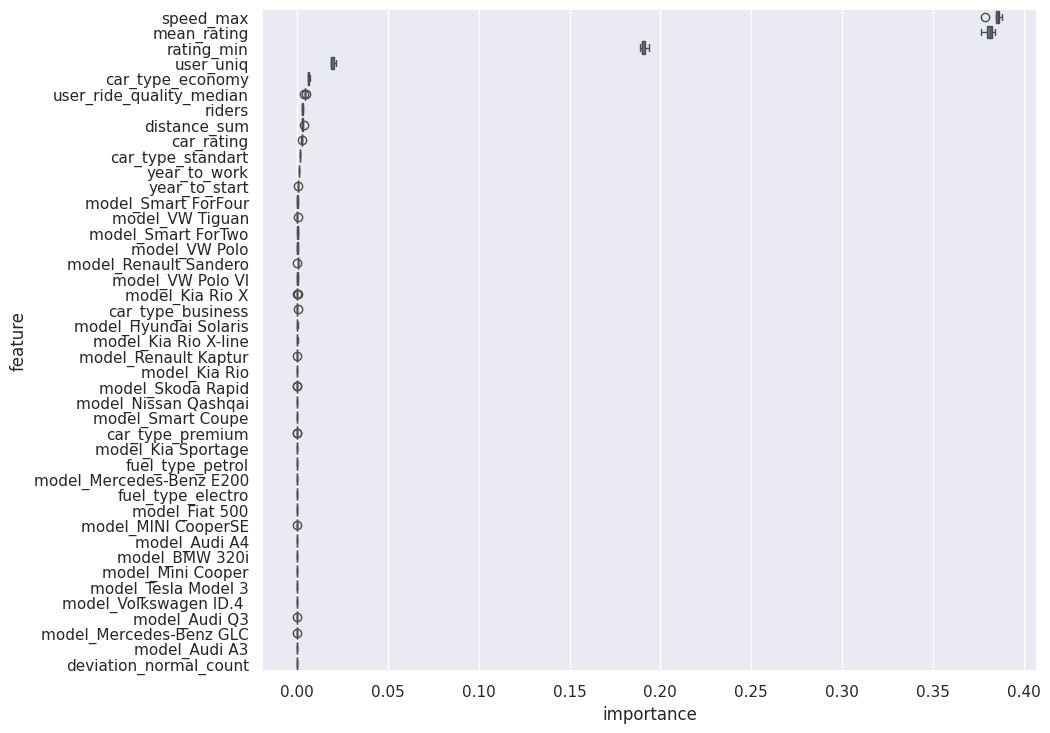

In [15]:
def plot_importance(df, best_model, height, top_n=50):

    top_n = min(top_n, df.shape[1])

    # Извлекаем значения из модели
    fi = pd.DataFrame(index=df.columns, columns=[])
    for i, m in enumerate(best_model):
        fi[f"m_{i}"] = m.feature_importances_

    fi = fi.stack().reset_index().iloc[:, [0, 2]]
    fi.columns = ["feature", "importance"]

    # Определяем порядок признаков и отбираем только n признаков для отрисовки
    cols_ord = (
        fi.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()[:top_n]
    )

    fi = fi[fi["feature"].isin(cols_ord)]  # Выравниваем порядок по убыванию важности
    print( "Всего признаков {} Усреднее по {}-ти моделям: ".format(len(cols_ord), len(best_model)))

    # Отрисовываем боксплоты фичей
    plt.figure(figsize=(10, len(cols_ord) * height))
    b = sns.boxplot(data=fi, y="feature", x="importance", orient="h", order=cols_ord)

    print("На график нанесено топ-{} признаков".format(top_n))
    return (
        fi.groupby(by=["feature"], as_index=False)["importance"]
        .mean()
        .sort_values(by="importance", ascending=False)
    )


df_feats_imp = plot_importance(
    train[filtered_features].drop(targets, axis=1, errors="ignore"),
    clfs,
    0.20,
    top_n=100,
)

<div class="alert alert-info">
    
# 🍒 Немного мыслей по итогу

* Разные валидации диверсифицируют модель
* Валидация ускоряет проверку гипотез
* `К-Fold` валидация дает вам несмещенную оценку значения метрики
* Если в постановке задачи или данных есть проблемы - вы об этом сразу узнаете
* Не все виды валидации можно настроить для любого размера данных